# Type de modulation

Le type de modulation est la modulation 1

# Generation des signaux

definition des fonctions utiles pour générer les signaux et afficher la constelation

In [16]:
import numpy as np
import scipy.integrate
from matplotlib import pyplot as plt

# fonctions de base du signal
cc= lambda t: np.sqrt(2)*np.cos(2.0*np.pi*t)
ss= lambda t: np.sqrt(2)*np.sin(2.0*np.pi*t)
def v (k):
    return lambda t: (2*(k%4-1)-1)*cc(t) + (2*(k//4-1)-1)*ss(t)

#fonctions de conversion des mots
def int_to_binaire(i):
    b=''
    while i>=1:
        b=str(i%2)+b
        i=i//2
    while (len(b)%4!=0):
        b="0"+b
    return b


def binaire_to_int(b):
    i=0; p=0;
    for c in reversed(b):
        if (c=='1'):
            i+=pow(2,p)
        p+=1
    return i
    
def str_to_binaire(s): 
    b=''
    for c in s:
        b+=int_to_binaire(ord(c))
    return b

#decoupe la chaine de bytes en morceaux de longueur t et stock les valeurs dans un tableau
def cut (s,t):
    while (len(s)%t!=0):
        s="0"+s
    s_cut=np.array([])
    mot=""
    i=1
    for b in s:
        mot+=b
        if(i==t):
            s_cut=np.append(s_cut,mot)
            mot=""
            i=0
        i=i+1
    return s_cut
    
#transforme une chaine de characteres en tableau de int utilisable 
def signal_int(mot,taille):
    signal=str_to_binaire(mot)
    signal=np.array(cut(signal,taille))
    for i in range(0,len(signal)):
        signal[i]=binaire_to_int(signal[i])
    return  signal

#module le signal d'apres la modulation choisie
def modul_signal(t,signal):
    m=np.array([v(int(signal[0]))(t)])
    for i in range(1,len(signal)):
        m=np.append(m,[v(int(signal[i]))(t)],axis=0)
    return m

#affiche les axes de facon esthetique
def genere_axes():
    ax = plt.gca() 
    ax.xaxis.set_label_coords(0.5,-0.05)
    ax.yaxis.set_label_coords(0,0.5)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))

#affiche les trois premiers mots du signal
def trois_premiers(t,s):
    genere_axes()
    plt.plot(t,s[0],label="mot 1")
    plt.plot(t,s[1],label="mot 2")
    plt.plot(t,s[2],label="mot 3")
    plt.legend(["mot 1","mot 2","mot 3"],loc='upper right')
    
#affiche la constellation
def constellation(t,signal,c='b'):
    genere_axes()
    for s in signal:
        x=scipy.integrate.simps(s*cc(t),t)
        y=scipy.integrate.simps(s*ss(t),t)
        plt.plot(np.array([x]),np.array([y]),c+'o')

On gérère le signal et on affiche les trois premiers mots en fonction du temps et la constellation

Pour la constellation certains points se chevauchent.

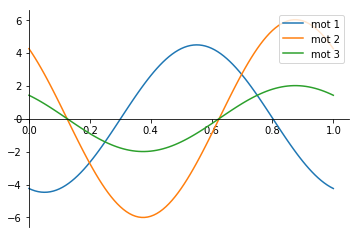

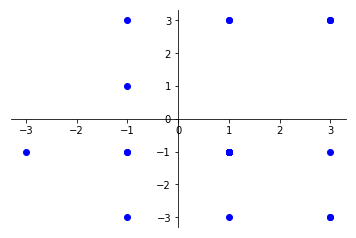

In [18]:
t=np.arange(0,1.0000001,0.01)
#tableau de int correspondant au text que l'on veut envoyer
signal=signal_int("CocogneRomain",4)
#tableau de signaux correspondant au tableau de int ci-dessus
s_module=modul_signal(t,signal)

trois_premiers(t,s_module)
plt.show()
constellation(t,s_module)
plt.show()

# energie moyenne

Ici il y a deux façons de faire. 
Soit on utilise le signal de base soit on utilise le signal modulé.
Les deux méthodes sont légèrement différentes puisque la première va recalculer le signal modulé à chaque itération.

A la main on trouve que l'energie d'un mot vaut:
(2*(k%4-1)-1)*(2*(k%4-1)-1)+(2*(k//4-1)-1)*(2*(k//4-1)-1)
avec k le mot converti en decimal.
en appliquant cette formule on trouve le même résultat

In [3]:
#premiere methode
def energy_moy(t,signal):
    moyenne=0
    for i in signal:
        moyenne+=scipy.integrate.simps(v(int(i))(t)*v(int(i))(t),t)
    return moyenne/len(signal)
#deuxieme methode
def energy_moy2(t,s):
    moyenne=0
    for i in s:
        moyenne+=scipy.integrate.simps(i*i,t)
    return moyenne/len(s)

#formule trouvee a la main
def energy_moy3(signal):
    moyenne =0
    for k in signal:
        k=int(k)
        moyenne+=(2*(k%4-1)-1)*(2*(k%4-1)-1)+(2*(k//4-1)-1)*(2*(k//4-1)-1)
    return moyenne/len(signal)

#les resultats sont les memes
print(energy_moy(t,signal))
print(energy_moy2(t,s_module))
print(energy_moy3(signal))

7.230769230769231
7.230769230769231
7.230769230769231


# addition du bruit blanc

On ajoute les fonctions bruitées et on redéfinit la modulation pour prendre en compte le bruit

In [25]:
#fonctions random de bruit
#on en fait deux differents pour le cosinus et le sinus 
#on utilise la 3eme methode pour calculer l'energie car cela evite de faire des integrales
b2_cos= lambda t: np.random.normal(0,energy_moy3(signal)/2,101)
b2_sin= lambda t: np.random.normal(0,energy_moy3(signal)/2,101)
b1_cos= lambda t: np.random.normal(0,energy_moy3(signal)/100,101)
b1_sin= lambda t: np.random.normal(0,energy_moy3(signal)/100,101)

#bruit avec l'energie 100 fois plus faible
def v_bruite_1(k):
    return lambda t: v(k)(t)+b1_cos(t)*cc(t)+b1_sin(t)*ss(t)
#bruit avec l'energie 2 fois plus faible
def v_bruite_2(k):
    return lambda t: v(k)(t)+b2_cos(t)*cc(t)+b2_sin(t)*ss(t)


def modul_signal(t,signal,b):
    if(b==0):
        m=np.array([v(int(signal[0]))(t)])
    elif (b==1):
        m=np.array([v_bruite_1(int(signal[0]))(t)])
    else:
        m=np.array([v_bruite_2(int(signal[0]))(t)])
    for i in range(1,len(signal)):
        if (b==0):
            m=np.append(m,[v(int(signal[i]))(t)],axis=0)
        elif (b==1):
            m=np.append(m,[v_bruite_1(int(signal[i]))(t)],axis=0)
        else:
            m=np.append(m,[v_bruite_2(int(signal[i]))(t)],axis=0)
    return m

# tracé

on trace les signaux bruités. on fait les trois premiers mots en fonction du temps et la constellation

bruit 1


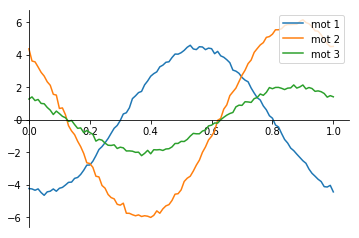

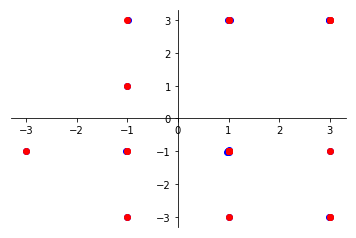

bruit 2


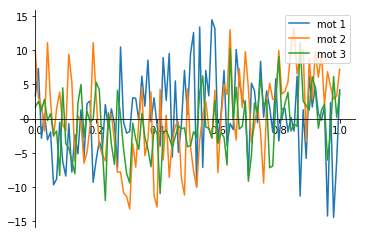

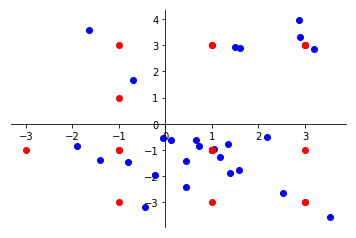

In [26]:
s_module_b1=modul_signal(t,signal,1)
s_module_b2=modul_signal(t,signal,2)

print("bruit 1")
#premier bruit
trois_premiers(t,s_module_b1)
plt.show()
constellation(t,s_module_b1)
constellation(t,s_module,'r')
plt.show()

print("bruit 2")
#deuxieme bruit
trois_premiers(t,s_module_b2)
plt.show()
constellation(t,s_module_b2)
constellation(t,s_module,'r')
plt.show()


# Recepteur

In [27]:
#reception d'un mot
#on le place sur la constellation et on cherche le signal le plus proche
def reception_mot(t,s):
    mot=0; 
    dp=10000; #distance entre deux points (on prend une grosse valeur pour etre large)
    x=scipy.integrate.simps(s*cc(t),t)
    y=scipy.integrate.simps(s*ss(t),t)
    for i in range(0,16):
        x_b=scipy.integrate.simps(v(i)(t)*cc(t),t)
        y_b=scipy.integrate.simps(v(i)(t)*ss(t),t)
        if ((x-x_b)*(x-x_b)+(y-y_b)*(y-y_b)<dp):
            dp=(x-x_b)*(x-x_b)+(y-y_b)*(y-y_b)
            mot=i
    return mot

#reception et conversion de tout les mots      
def reception (t,s):
    mot_binaire=''
    for m in range (len(s)):
        mot_binaire+=int_to_binaire(reception_mot(t,s[m]))
    lettre='';mot=''
    for b in mot_binaire:
        lettre+=b
        if(len(lettre)%8==0):
            mot+=chr(int(binaire_to_int(lettre)))
            lettre=''
    return mot

On voit bien que le premier bruit semble donner une erreur nulle, contrairement au second bruit.

Pour reinitialiser le signal, penser a recompiler la partie "tracé" où les variables s_module_b1 et s_module_b2 sont définis.

In [30]:
print(reception(t,s_module))
print(reception(t,s_module_b1))
print(reception(t,s_module_b2))

CocogneRomain
CocogneRomain
SocognURomai^


# taux d'erreur

J'ai remarqué que changer la définition du signal (passer les vecteurs temps et bruit de 101 points à 1001 points par exemple) faisait diminuer l'erreur drastiquement. Je ne sais pas comment expliquer ce phénomène.

In [31]:
def erreur_mot (t,signal,n,b):
    erreur=0
    for i in range(n):
        if(reception_mot(t,modul_signal(t,signal,b)[i%16]) != int(signal[i%16])):
            erreur+=1
    print("nombre d'erreur:"+ str(erreur))
    return erreur/n

def erreur_byte (t,signal,n,b):
    erreur=0
    for i in range(n):
        mot_rec_byte= int_to_binaire(reception_mot(t,modul_signal(t,signal,b)[i%16]))
        mot_env_byte= int_to_binaire(int(signal[i%16]))
        for j in range(len(mot_rec_byte)):
            if(mot_env_byte[j] != mot_rec_byte[j]):
                erreur+=1
    print("nombre d'erreur:"+ str(erreur))
    return erreur/(n*4) #on fait fois 4 car chaque mot est compose de 4 bytes

pour de grand nombres le calcul prend beaucoup de temps, probablement à cause des intégrales. 

Pour le premier bruit, il est impossible d'avoir une erreur peut importe le nombre de mots envoyés.

#### Erreur de mots du bruit 1

In [9]:
print(str(erreur_mot(t,signal,100000,1)*100)+"%")

nombre d'erreur:0
0.0%


#### Erreur bytes du bruit 1

In [32]:
print(str(erreur_byte(t,signal,1000,1)*100)+"%")

nombre d'erreur:0
0.0%


#### Erreur de mots du bruit 2

In [28]:
print(str(erreur_mot(t,signal,1000,2)*100)+"%")

nombre d'erreur:116
11.600000000000001%


#### Erreur de bytes du bruit 2

In [33]:
print(str(erreur_byte(t,signal,1000,2)*100)+"%")

nombre d'erreur:133
3.325%
